## Manual Analysis Using SQL

To complement the outputs generated by our anomaly-detection models, we now perform a structured manual analysis using SQL queries directly on the combined dataset.

The goal of this stage is to understand how the flagged transactions behave in practice, uncovering patterns that may not be immediately visible from model scores alone.

This step is especially valuable because it allows us to:
- Examine where the models strongly agree (High Consensus cases).
- Identify which suppliers (favorecidos) appear most frequently.
- Understand the geographic distribution of high-consensus transactions.
- Distinguish between sigiloso (confidential) and non-confidential transactions.
- Validate whether the detected anomalies align with what an auditor would consider suspicious or worth reviewing.

Using SQL for this investigation offers a transparent and easily interpretable way to filter, aggregate, and inspect the data.
It creates a natural bridge between the machine-learning scores and the audit logic that will guide the human reviewer.

In the following cells, we progressively explore different dimensions of the High Consensus cases to better understand the patterns highlighted by our models.

### Preparing the environment for the manual SQL-based investigation.
We begin by importing the core analytical libraries:
- Pandas for data manipulation
- NumPy for numerical operations
- Matplotlib for plotting. 

The essential step here is the creation of the pysqldf function. This small wrapper allows us to execute SQL queries directly on our in-memory dataframes using the pandasql engine. By passing the global namespace, any dataframe defined in the notebook becomes accessible to SQL without additional configuration.

With this setup in place, we can now run expressive SQL statements on df and its filtered subsets, enabling us to explore patterns in the model outputs in a way that is straightforward, transparent, and easy to interpret for auditing purposes.

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from pandasql import sqldf

# 1. Define the query function
pysqldf = lambda q: sqldf(q, globals())

### Project functions properly imported and always up to date during development.
The %reload_ext autoreload command enables automatic reloading of Python modules when their source code changes, which is useful in iterative workflows where functions evolve while the notebook remains running.

We then extend the Python path to include the parent directory, allowing the notebook to access the project’s modularized codebase. This makes it possible to import the pipeline functions directly from our functions directory without restructuring the environment.

Finally, we load the three core components of the project pipeline:
- run_pipeline — responsible for orchestrating the full data preparation and scoring flow.
- combine_dataframes — used to merge model outputs into a unified dataset.
- calculate_priority_score — which produces the final prioritization score used in the audit process.

With these imports, the notebook is now connected to the project’s main code modules and ready to execute the full anomaly-detection pipeline.

In [2]:
%reload_ext autoreload
sys.path.append(os.path.abspath('..'))
from functions.pipeline import run_pipeline, combine_dataframes, calculate_priority_score

This line defines the path to the directory where the raw CPGF data files are stored. By assigning it to the variable raw_path, we centralize the reference to the input data location, making it easier to reuse throughout the notebook and to adjust later if the directory structure changes.

Using a relative path (../raw_data/) ensures that the notebook remains portable inside the project folder, regardless of where it is executed, as long as the overall project structure is maintained.

In [3]:
raw_path = '../raw_data/'

### Running our pipeline

This command executes the full anomaly-detection pipeline using the raw data directory defined earlier.
By calling run_pipeline(raw_path), we trigger all major steps of preprocessing and feature construction that were implemented in the project modules:

- loading and consolidating the raw monthly files,
- cleaning and standardizing the data,
- engineering contextual features,
- running the LOF and Isolation Forest models, and
- producing the intermediate scoring outputs.

The resulting dataframe, stored in df_pipeline, contains the enriched dataset ready for the next stage of analysis. This is the foundation upon which we will later compute the final technical and financial risk scores and perform the manual audit exploration.

In [4]:
df_pipeline = run_pipeline(raw_path)

### Unpacking our dataframes

In this step, we unpack the intermediate outputs produced by the pipeline.
The pipeline separates the results of each anomaly-detection model into two groups:

- classified — observations that are "sigiloso"
- normal — observations that are "non-sigiloso"

By extracting these four dataframes:

- df_lof_classified
- df_lof_normal
- df_if_classified
- df_if_normal

we obtain explicit access to the predictions generated by both the Local Outlier Factor (LOF) model and the Isolation Forest model. This separation allows us to later recombine the outputs in a controlled way, normalize their scores, and inspect how each model behaves before constructing the final priority score.

These structured subsets are essential for analyzing agreement between models and for understanding the distribution of anomalies across the dataset.

In [5]:
df_lof_classified = df_pipeline['lof_classified']
df_lof_normal = df_pipeline['lof_normal']
df_if_classified = df_pipeline['if_classified']
df_if_normal = df_pipeline['if_normal']

### Combining our dataframes

Now we merge the outputs of both models into a single unified dataset.
The function combine_dataframes() takes the four input dataframes (LOF classified/normal and IF classified/normal) and aligns them by:

- Concatenating the classified and normal outputs for each model,
- Assigning a unique ID to each transaction,
- Selecting only the relevant label and score columns,
- Merging LOF and IF information into one consolidated structure.
- The result is df_combined, a single dataframe that stores, for every transaction:

- the LOF label and score,
- the IF label and score,

and all associated metadata.

This unified view becomes the basis for the normalization step and the subsequent calculation of the technical and priority scores.

In [6]:
df_combined = combine_dataframes(df_lof_classified, df_lof_normal, df_if_classified, df_if_normal)

### Calculating our priority score

Now that we have the combined dataset, the next step is to compute all the scoring components that will later drive our anomaly-review process.
The function calculate_priority_score() performs this in three stages:

- Technical Score
It averages the normalized LOF and IF scores to obtain a single technical measure of anomaly intensity.

- Financial Risk
It takes the logarithm of the transaction value and normalizes it, so that unusually large amounts contribute proportionally more risk.

- Priority Score
Finally, it combines both dimensions using our chosen weighting:

- 70% technical anomaly strength
- 30% financial relevance

The output df is the fully scored dataset, ordered by priority, ready for filtering, ranking, and manual inspection.

In [7]:
df = calculate_priority_score(df_combined)

## Querying top 200 suspicious transactions

To focus our manual review on the most relevant transactions, we used the distribution of the normalized LOF and IF scores to define data-driven consensus thresholds.
Because each model produces a different numerical range, fixed cutoffs would not be meaningful. Instead, we extracted percentile-based limits:

92nd percentile → marks moderately high anomaly scores
97th percentile → marks extremely high anomaly scores

With these thresholds, we define three levels of agreement between the models:

- High Consensus: both LOF and IF exceed their respective 97th percentiles
- Medium Consensus: at least one score exceeds its 92nd percentile
- Low Consensus: neither score reaches these anomaly regions

Using SQL, we then query the 200 transactions with the highest priority score and classify each one into these consensus categories. This gives us a compact audit sample where model agreement is explicit and easy to inspect.

In [8]:
# Working with percentile works better on this situation
lof_92 = df_combined['LOF_SCORE_NORM'].quantile(0.92)
if_92  = df_combined['IF_SCORE_NORM'].quantile(0.92)

lof_97 = df_combined['LOF_SCORE_NORM'].quantile(0.97)
if_97  = df_combined['IF_SCORE_NORM'].quantile(0.97)

# Creating the dataframe with the top 200 suspicious transactions
query_top_200 = f"""
SELECT
    *,
    CASE
        WHEN LOF_SCORE_NORM > {lof_97} AND IF_SCORE_NORM > {if_97}
            THEN 'High Consensus'
        WHEN LOF_SCORE_NORM > {lof_92} OR IF_SCORE_NORM > {if_92}
            THEN 'Medium Consensus'
        ELSE 'Low Consensus'
    END AS Consensus_Type
FROM
    df
ORDER BY
    PRIORITY_SCORE DESC
LIMIT 200;
"""

df_audit = pysqldf(query_top_200)

print(f"Extracted {len(df_audit)} transactions for manual audit.")

Extracted 200 transactions for manual audit.


### What is driving the priority score?

Before diving into the content of each flagged transaction, it is useful to understand what is driving their prioritization.
Since our final priority score is a weighted combination of:

- Technical evidence of anomaly (70%)
- Financial relevance (30%)

We examine the numerical distribution of these three components within the audit sample.
By comparing their descriptive statistics, we can quickly see whether the top-ranked observations were selected mainly because:

- they were highly anomalous according to LOF/IF (high technical score),
- they involved large monetary values (high financial risk),
- or a mixture of both.

This step helps interpret model behavior and highlights whether our pipeline is emphasizing the factors we consider most important.

In [9]:
# Check how many transactions were driven primarily by financial vs. technical scores
df_audit[['TECHNICAL_SCORE', 'FINANCIAL_RISK', 'PRIORITY_SCORE']].describe()

,TECHNICAL_SCORE,FINANCIAL_RISK,PRIORITY_SCORE
count,200.000000,200.000000,200.000000
mean,27365.685548,0.720846,19156.196138
std,66716.701731,0.162423,46701.690097
min,9826.770379,-0.826250,6878.972502
25%,12365.874022,0.731209,8656.336241
50%,18840.641829,0.777456,13188.651888
75%,26611.514195,0.777456,18628.136915
max,932864.685305,0.889827,653005.512950


### Dataframe with only 'High Consensus'

To better understand the subset of transactions where both models strongly agree, we isolate all observations labeled as High Consensus.
These are the cases where:

LOF and Isolation Forest both place the transaction within the highest anomaly percentile, according to our thresholding strategy.

Extracting this subset allows us to manually inspect:

- which operational contexts these anomalies come from,
- whether they cluster around specific units, states, or beneficiaries,
- how consistent the patterns are across both models.

Since these are the transactions with the strongest dual-model signal, they are especially important for deeper investigation.

Before exploring the characteristics of the High Consensus transactions, we remove several intermediate or engineered variables that are not needed for manual audit. These include internal model scores, frequency features, and technical helper columns created during preprocessing.

The goal is to keep the dataset focused on the attributes that matter most for human review—such as organizational information, beneficiary details, transaction metadata, and the final priority score. 

In [10]:
# Check what are the transactions labeled as High Consensus
query_high_consensus = """
SELECT
    ID,
    "CÓDIGO ÓRGÃO SUPERIOR",
    "NOME ÓRGÃO SUPERIOR",
    "CÓDIGO ÓRGÃO",
    "NOME ÓRGÃO",
    "CÓDIGO UNIDADE GESTORA",
    "NOME UNIDADE GESTORA",
    "ANO EXTRATO",
    "MÊS EXTRATO",
    "CNPJ OU CPF FAVORECIDO",
    "NOME FAVORECIDO",
    "TRANSAÇÃO",
    "DATA TRANSAÇÃO",
    "VALOR TRANSAÇÃO",
    ARQUIVO_ORIGEM,
    ESTADO_ESTIMADO,
    SIGILOSO,
    ID_PORTADOR,
    FIM_SEMANA,
    PRIORITY_SCORE,
    Consensus_Type
FROM
    df_audit
WHERE
    Consensus_Type = 'High Consensus';
"""

In [11]:
query_consensus_breakdown = """
SELECT
    Consensus_Type,
    COUNT(*) AS Count,
    COUNT(*) * 1.0 / (SELECT COUNT(*) FROM df_audit) AS Proportion
FROM
    df_audit
GROUP BY
    Consensus_Type
ORDER BY
    Proportion DESC;
"""
df_consensus_summary = pysqldf(query_consensus_breakdown)

print("Breakdown of Model Agreement (Proportional):")
display(df_consensus_summary)

Breakdown of Model Agreement (Proportional):


,Consensus_Type,Count,Proportion
0,Medium Consensus,150,0.75
1,High Consensus,50,0.25


We now display the cleaned version of df_high, containing only the fields relevant for human inspection.
This view allows us to directly examine each High Consensus transaction, looking for recognizable patterns such as:

- recurring beneficiaries or units,
- unusual types of transactions,
- geographic concentration,
- outlier transaction values.

Seeing the data laid out in its final audit-ready form provides the foundation for the detailed manual analysis that follows.

In [12]:
df_high = pysqldf(query_high_consensus)
display(df_high.head(10))

,ID,CÓDIGO ÓRGÃO SUPERIOR,NOME ÓRGÃO SUPERIOR,CÓDIGO ÓRGÃO,NOME ÓRGÃO,CÓDIGO UNIDADE GESTORA,NOME UNIDADE GESTORA,ANO EXTRATO,MÊS EXTRATO,CNPJ OU CPF FAVORECIDO,...,TRANSAÇÃO,DATA TRANSAÇÃO,VALOR TRANSAÇÃO,ARQUIVO_ORIGEM,ESTADO_ESTIMADO,SIGILOSO,ID_PORTADOR,FIM_SEMANA,PRIORITY_SCORE,Consensus_Type
0,193577,39000,Ministério dos Transportes,29209,"VALEC Engenharia, Construções e Ferrovias S.A.",275075,"VALEC ENGENHARIA, CONSTRUCOES E FERROVIAS S.A",2025,3,-2,...,SAQUE CASH/ATM BB,2025-02-11 00:00:00.000000,1000.0,202503_CPGF.csv,UNIÃO,0,***.264.331-**LEANDRO FRANCO PEDROZA,0,653005.512950,High Consensus
1,160721,44000,Ministério do Meio Ambiente e Mudança do Cl,44000,Ministério do Meio Ambiente e Mudança do Clima...,440001,"SUBSECRET.DE PLANEJ.,ORC.E ADMINIST.±SPOA/MM",2023,2,-2,...,SAQUE CASH/ATM BB,2023-01-05 00:00:00.000000,1000.0,202302_CPGF.csv,UNIÃO,0,***.283.371-**ROBERT WILLIAM CARDOSO DE PAULA,0,111462.768939,High Consensus
2,30941,44000,Ministério do Meio Ambiente e Mudança do Cl,44207,Instituto Chico Mendes de Conservação da Biodi...,443033,INSTITUTO CHICO MENDES - SEDE,2025,1,-2,...,SAQUE CASH/ATM BB,2024-11-24 00:00:00.000000,1000.0,202501_CPGF.csv,UNIÃO,0,***.689.962-**DIERLEY MORAIS DE ARAUJO,1,65625.849586,High Consensus
3,30938,44000,Ministério do Meio Ambiente e Mudança do Cl,44207,Instituto Chico Mendes de Conservação da Biodi...,443033,INSTITUTO CHICO MENDES - SEDE,2025,1,-2,...,SAQUE CASH/ATM BB,2024-12-01 00:00:00.000000,1000.0,202501_CPGF.csv,UNIÃO,0,***.443.198-**IVALDO MARQUES DA SILVA,1,65625.312647,High Consensus
4,30939,44000,Ministério do Meio Ambiente e Mudança do Cl,44207,Instituto Chico Mendes de Conservação da Biodi...,443033,INSTITUTO CHICO MENDES - SEDE,2025,1,-2,...,SAQUE CASH/ATM BB,2024-11-30 00:00:00.000000,1000.0,202501_CPGF.csv,UNIÃO,0,***.443.198-**IVALDO MARQUES DA SILVA,1,65625.269144,High Consensus
5,219504,20000,Presidência da República,20101,Presidência da República,110001,SECRETARIA DE ADMINISTRACAO/PR,2024,1,-2,...,SAQUE CASH/ATM BB,2023-12-20 00:00:00.000000,1000.0,202401_CPGF.csv,DF,0,***.238.203-**LUCIANO BUARQUE BARBOSA,0,61557.428369,High Consensus
6,33049,39000,Ministério dos Transportes,29209,"VALEC Engenharia, Construções e Ferrovias S.A.",275075,"VALEC ENGENHARIA, CONSTRUCOES E FERROVIAS S.A",2025,1,-2,...,SAQUE CASH/ATM BB,2024-12-20 00:00:00.000000,600.0,202501_CPGF.csv,UNIÃO,0,***.264.331-**LEANDRO FRANCO PEDROZA,0,55392.851525,High Consensus
7,33050,39000,Ministério dos Transportes,29209,"VALEC Engenharia, Construções e Ferrovias S.A.",275075,"VALEC ENGENHARIA, CONSTRUCOES E FERROVIAS S.A",2025,1,-2,...,SAQUE CASH/ATM BB,2024-12-20 00:00:00.000000,400.0,202501_CPGF.csv,UNIÃO,0,***.264.331-**LEANDRO FRANCO PEDROZA,0,42054.874326,High Consensus
8,160722,44000,Ministério do Meio Ambiente e Mudança do Cl,44000,Ministério do Meio Ambiente e Mudança do Clima...,440001,"SUBSECRET.DE PLANEJ.,ORC.E ADMINIST.±SPOA/MM",2023,2,-2,...,SAQUE CASH/ATM BB,2023-01-05 00:00:00.000000,500.0,202302_CPGF.csv,UNIÃO,0,***.283.371-**ROBERT WILLIAM CARDOSO DE PAULA,0,41674.362242,High Consensus
9,30963,44000,Ministério do Meio Ambiente e Mudança do Cl,44207,Instituto Chico Mendes de Conservação da Biodi...,443033,INSTITUTO CHICO MENDES - SEDE,2025,1,-2,...,SAQUE CASH/ATM BB,2024-12-02 00:00:00.000000,60.0,202501_CPGF.csv,UNIÃO,0,***.832.192-**JOSE RISONEI ASSIS DA SILVA,0,40657.559619,High Consensus


### Temporal distribution of anomalies

This query examines the temporal distribution of anomalies by breaking down the high consensus dataset across two dimensions:

- Month of the transaction (Anomaly_Month)
- Day of the week (Day_of_Week, where 0=Sunday and 6=Saturday)

By grouping and counting the number of anomalous transactions for each month–weekday combination, we can identify periods with unusually high concentrations of high-risk activity.

This helps answer questions such as:

- Are anomalies more frequent on specific days of the week?
- Are certain months associated with peaks in suspicious behavior?
- Do weekends show a different anomaly pattern compared to weekdays?

The table displays the top 10 (month, weekday) combinations with the largest number of flagged transactions, giving an initial view of when anomalous activity clusters most strongly.

In [13]:
query_temporal_risk = """
SELECT
    CAST(STRFTIME('%Y-%m', "DATA TRANSAÇÃO") AS TEXT) AS Anomaly_Month,
    CAST(STRFTIME('%w', "DATA TRANSAÇÃO") AS INTEGER) AS Day_of_Week, -- 0=Sunday, 6=Saturday
    COUNT(*) AS Anomaly_Count
FROM
    df_high
GROUP BY
    Anomaly_Month, Day_of_Week
ORDER BY
    Anomaly_Count DESC;
"""
df_temporal_summary = pysqldf(query_temporal_risk)
print("Risk Count by Month and Day of Week:")
display(df_temporal_summary.head(10))

Risk Count by Month and Day of Week:


,Anomaly_Month,Day_of_Week,Anomaly_Count
0,2022-12,1,7
1,2023-12,6,4
2,2024-12,1,4
3,2022-12,2,3
4,2024-11,3,3
5,2022-12,3,2
6,2023-01,4,2
7,2023-11,6,2
8,2024-11,1,2
9,2024-12,3,2


The table highlights the (month, weekday) combinations with the highest concentration of anomalous transactions.
A few patterns stand out immediately:

- December appears repeatedly across multiple years (2022, 2023, 2024), suggesting that the end-of-year period has a consistently higher occurrence of flagged transactions.
- Weekdays such as Monday (1) and Tuesday (2) show multiple high-frequency entries, indicating that anomalies tend to cluster at the start of the workweek.
- Saturdays (6) also appear in the top results, which is unusual for regular administrative activity and may warrant closer inspection.
- The recurrence of the same month–weekday (end of year) combinations across different years hints at structural seasonal behavior, not random noise.

This temporal breakdown helps identify when anomalies are most likely to occur, guiding both investigative focus and future monitoring strategies.

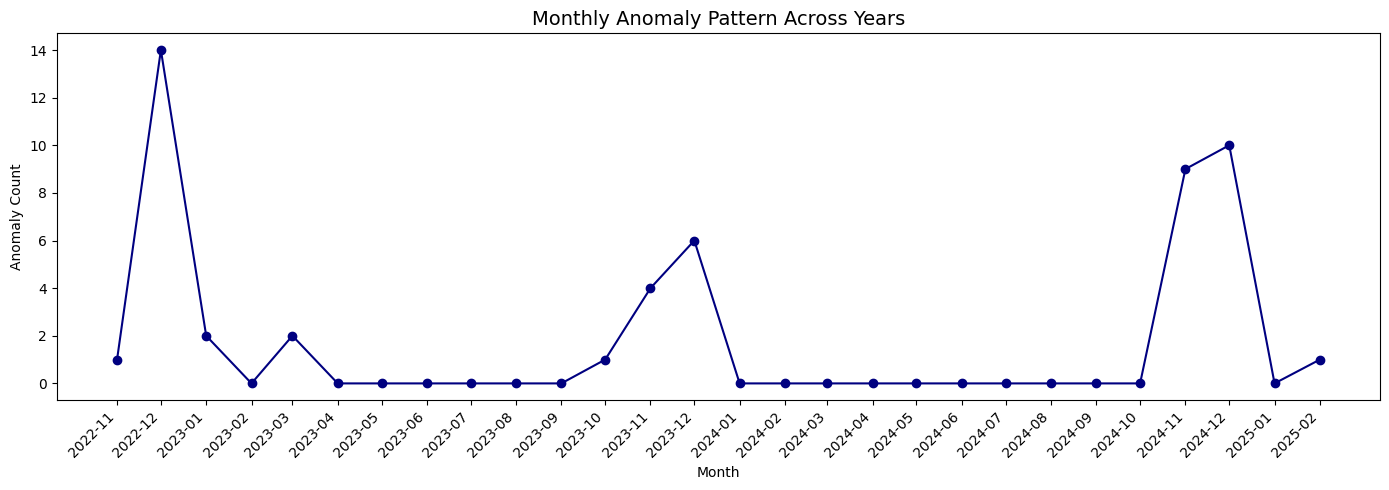

In [32]:
# 1. Copy and prepare the data
df_temp = df_temporal_summary.copy()
df_temp["Anomaly_Month"] = pd.to_datetime(df_temp["Anomaly_Month"])

# 2. Build a complete monthly index from min to max date
full_range = pd.date_range(
    start=df_temp["Anomaly_Month"].min(),
    end=df_temp["Anomaly_Month"].max(),
    freq='MS'   # Month start frequency
)

df_full = pd.DataFrame({"Anomaly_Month": full_range})

# 3. Merge anomaly counts onto full monthly timeline
df_full = df_full.merge(
    df_temp.groupby("Anomaly_Month")["Anomaly_Count"].sum().reset_index(),
    on="Anomaly_Month",
    how="left"
)

# 4. Replace missing months with zero anomalies
df_full["Anomaly_Count"] = df_full["Anomaly_Count"].fillna(0)

# 5. Plot the full sequence to see yearly repeating waves
plt.figure(figsize=(14,5))
plt.plot(
    df_full["Anomaly_Month"],
    df_full["Anomaly_Count"],
    marker="o",
    color='navy'
)

plt.title("Monthly Anomaly Pattern Across Years", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Anomaly Count")

plt.xticks(
    df_full["Anomaly_Month"],
    df_full["Anomaly_Month"].dt.strftime("%Y-%m"),
    rotation=45,
    ha="right"
)

plt.tight_layout()
plt.show()

### Weekend or not?

When checking whether High Consensus transactions occurred on weekends (FIM_SEMANA), we find:

- 12 transactions were executed during weekends (1)
- 37 transactions occurred on weekdays (0)

This distribution shows that weekend spending is present but not dominant.

Weekend activity can sometimes indicate atypical operational patterns, the presence of several weekend transactions may warrant closer individual review, especially when combined with other anomalies such as unusual beneficiaries or high transaction values.

In [15]:
query_weekend_counts = """
SELECT
    FIM_SEMANA,
    COUNT(*) AS Frequency
FROM
    df_high
GROUP BY
    FIM_SEMANA
ORDER BY
    Frequency DESC;
"""

df_weekend_counts = pysqldf(query_weekend_counts)
print("Weekend vs. Non-Weekend Counts:")
display(df_weekend_counts)

Weekend vs. Non-Weekend Counts:


,FIM_SEMANA,Frequency
0,0,38
1,1,12


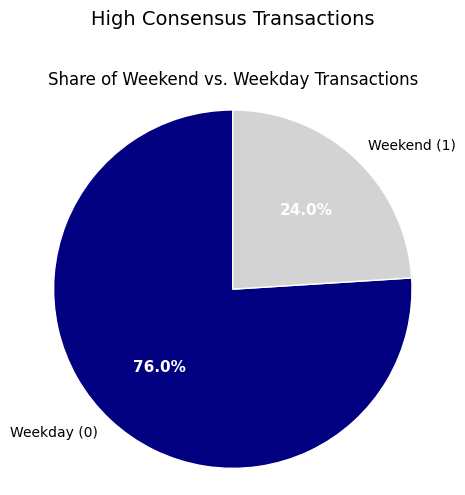

In [33]:
# Value counts
counts = df_high['FIM_SEMANA'].value_counts().sort_index()

# Define colors: Weekday (navy), Weekend (light grey)
colors = ["navy", "lightgrey"]

# Pie Chart
fig, ax = plt.subplots(figsize=(5, 5))

wedges, texts, autotexts = ax.pie(
    counts.values,
    labels=["Weekday (0)", "Weekend (1)"],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops={"edgecolor": "white", "linewidth": 1}
)

# Improve percentage text readability
for autotext in autotexts:
    autotext.set_color("white")
    autotext.set_fontsize(11)
    autotext.set_fontweight("bold")

# Title + subtitle
plt.suptitle("High Consensus Transactions\n", fontsize=14)
ax.set_title("Share of Weekend vs. Weekday Transactions", fontsize=12)

# Ensure perfect circle
ax.axis('equal')

plt.tight_layout()
plt.show()

### Transaction type

This query analyzes how different transaction types (TRANSAÇÃO) behave within the high consensus sample. By counting how many anomalous events fall into each category and computing their average priority score, we gain insight into which types of transactions are most frequently flagged by the models.

A high anomaly count for a given transaction type suggests recurring patterns that deviate from normal behavior, for example, repeated reimbursement transactions with unusual values or suspicious timing. Meanwhile, the Avg_Priority metric helps distinguish between transaction types that are commonly flagged but relatively low-risk and those that, even if less frequent, carry higher combined technical and financial risk.

Together, these two dimensions allow us to identify transaction types that may warrant increased scrutiny in future monitoring efforts, as they represent structural patterns in the dataset rather than isolated events.

In [17]:
query_transacao_risk = """
SELECT
    "TRANSAÇÃO",
    COUNT(*) AS Anomaly_Count,
    AVG("PRIORITY_SCORE") AS Avg_Priority
FROM
    df_high
GROUP BY
    "TRANSAÇÃO"
ORDER BY
    Anomaly_Count DESC;
"""
df_transacao_summary = pysqldf(query_transacao_risk)
print("\n--- E. Anomaly Count by Transaction Type ---")
display(df_transacao_summary)


--- E. Anomaly Count by Transaction Type ---


,TRANSAÇÃO,Anomaly_Count,Avg_Priority
0,SAQUE CASH/ATM BB,49,37029.133179
1,SAQUE - INT$ - APRES,1,10017.045171


The analysis of transaction types revealed a striking pattern: 100% of the high-priority anomalies correspond to the category “SAQUE CASH/ATM BB”, meaning all flagged transactions were cash withdrawals. This concentration is unusual, because in typical corporate or public-sector spending datasets, withdrawals represent only a small fraction of total activity.

Such a one-category dominance suggests that the anomaly-detection models (both LOF and IF) consistently classify cash withdrawals as high-risk behavior, likely because these operations lack detailed documentation, reduce traceability, and often deviate from the expected digital payment patterns.

In practical terms, this strongly indicates that withdrawals are the primary operational vector associated with potential irregularities, and they warrant closer manual review.

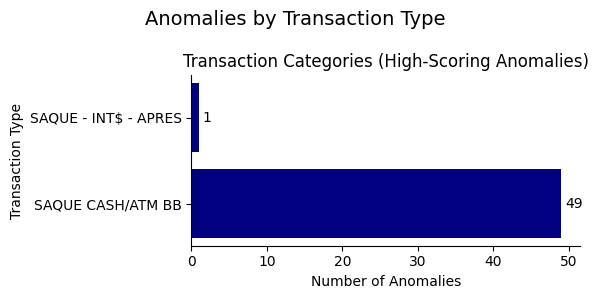

In [35]:
# Select top N transaction types for readability
top_n = 15
df_plot = df_transacao_summary.head(top_n)

plt.figure(figsize=(6,3))

# Horizontal bar chart (helps with long text labels)
bars = plt.barh(df_plot["TRANSAÇÃO"], df_plot["Anomaly_Count"], color='navy')

# Titles
plt.suptitle("Anomalies by Transaction Type", fontsize=14)
plt.title(f"Transaction Categories (High-Scoring Anomalies)", fontsize=12)

# Axis labels
plt.xlabel("Number of Anomalies")
plt.ylabel("Transaction Type")

# Add labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 0.5,                       # small offset
        bar.get_y() + bar.get_height() / 2,
        f"{int(width)}",
        va="center",
        fontsize=10
    )
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.show()

### Who received the money?

This step examines the entities receiving the transactions identified as potentially anomalous by both models. By grouping the records by NOME FAVORECIDO, we can see which recipients accumulate the largest total transaction value within the high-priority audit set. This perspective is useful because certain favorecidos may not appear frequently, but when they do, the associated amounts are unusually large, a pattern often associated with concentrated financial risk. 

In [19]:
query_favored_risk = """
SELECT
    "NOME FAVORECIDO",
    COUNT(*) AS Anomaly_Count,
    SUM("VALOR TRANSAÇÃO") AS Total_Anomalous_Value
FROM
    df_high
GROUP BY
    "NOME FAVORECIDO"
ORDER BY
    Total_Anomalous_Value DESC
LIMIT
    10;
"""
df_favored_summary = pysqldf(query_favored_risk)
print("\n--- D. Top 4 Favored Entities by Total Anomalous Value ---")
display(df_favored_summary)


--- D. Top 4 Favored Entities by Total Anomalous Value ---


,NOME FAVORECIDO,Anomaly_Count,Total_Anomalous_Value
0,NAO SE APLICA,50,41904.6


To complement the SQL summary, the bar chart shows the most common favorecidos specifically within the High Consensus subset. While the SQL table highlights the financial magnitude of each recipient, the plot reveals how often each favorecido appears. 

As you can see, mostly are "Non applicable" because like we saw earlier, these were a result of directly money withdraw. 

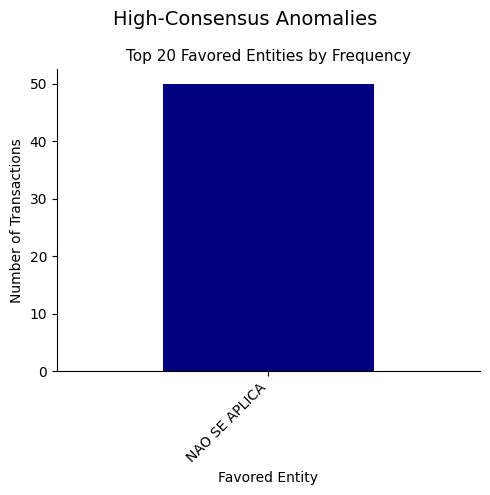

In [37]:
plt.figure(figsize=(5, 5))

# Bar chart in navy blue
df_high['NOME FAVORECIDO'] \
    .value_counts() \
    .head(20) \
    .plot(kind='bar', color='navy')

# Titles
plt.suptitle("High-Consensus Anomalies", fontsize=14)
plt.title("Top 20 Favored Entities by Frequency", fontsize=11)

# Axis labels
plt.xlabel("Favored Entity")
plt.ylabel("Number of Transactions")

# Improve label readability
plt.xticks(rotation=45, ha='right')

# Clean spines for a modern look
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

### Transaction value

In this step, we examine how the transaction values are distributed within the High Consensus group.
The goal is to understand whether the model is flagging mostly low-value anomalies, high-value anomalies, or a mixture of both. A simple count of unique values is not very informative on its own, so we visualize the distribution using a histogram.

By looking at this histogram, we can quickly identify whether:

- anomalies cluster around specific monetary ranges,
- there are unusually high-value transactions among the most suspicious cases, and
- the model prioritizes financial risk or technical irregularities when both signals disagree.

This visualization helps us validate whether the priority scoring is behaving as expected and whether high-value outliers are being surfaced appropriately for audit.

In [21]:
query_transaction_value = """
SELECT
    COUNT(*) AS Total_Transactions,
    SUM("VALOR TRANSAÇÃO") AS Total_Value,
    AVG("VALOR TRANSAÇÃO") AS Avg_Value,
    MIN("VALOR TRANSAÇÃO") AS Min_Value,
    MAX("VALOR TRANSAÇÃO") AS Max_Value
FROM
    df_high;
"""

df_value_transaction = pysqldf(query_transaction_value)

# Add statistics that SQLite cannot compute
df_value_transaction["Median_Value"] = df_high["VALOR TRANSAÇÃO"].median()
df_value_transaction["StdDev_Value"] = df_high["VALOR TRANSAÇÃO"].std()

print("Distribution of Anomalous Value:")
display(df_value_transaction)

Distribution of Anomalous Value:


,Total_Transactions,Total_Value,Avg_Value,Min_Value,Max_Value,Median_Value,StdDev_Value
0,50,41904.6,838.092,60.0,1014.6,1000.0,246.841399


In [22]:
query_value_counts = """
SELECT
    "VALOR TRANSAÇÃO" AS Transaction_Value,
    COUNT(*) AS Frequency
FROM
    df_high
GROUP BY
    "VALOR TRANSAÇÃO"
ORDER BY
    Frequency DESC;
"""

df_value_counts = pysqldf(query_value_counts)
print("Frequency of Transaction Values:")
display(df_value_counts)

Frequency of Transaction Values:


,Transaction_Value,Frequency
0,1000.0,28
1,500.0,3
2,800.0,2
3,600.0,2
4,1014.6,1
5,970.0,1
6,950.0,1
7,930.0,1
8,900.0,1
9,780.0,1


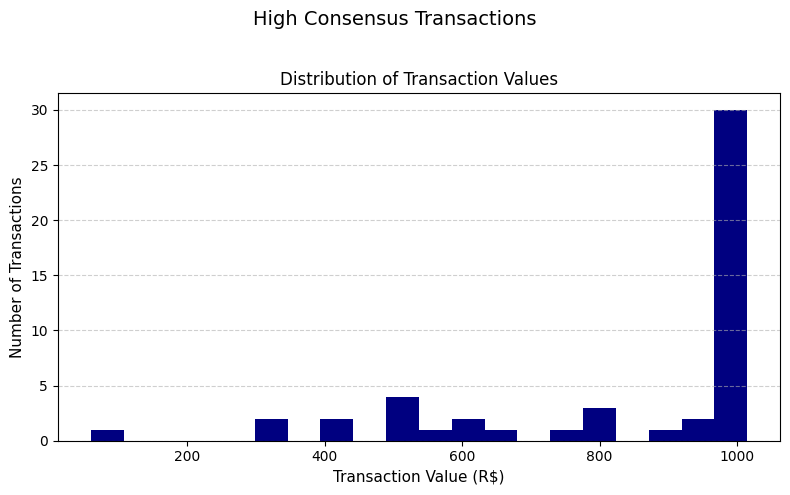

In [39]:
plt.figure(figsize=(8, 5))

# Histogram
plt.hist(df_high['VALOR TRANSAÇÃO'], bins=20, color='navy')

# Labels
plt.xlabel("Transaction Value (R$)", fontsize=11)
plt.ylabel("Number of Transactions", fontsize=11)

# Title + subtitle
plt.suptitle("High Consensus Transactions\n", fontsize=14)
plt.title("Distribution of Transaction Values", fontsize=12)

# Grid for readability
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

### Distribution per State 

In this step, we examine how high-consensus anomalies are distributed across Brazilian states. The SQL query groups the suspicious transactions by the variable ESTADO_ESTIMADO and computes three important metrics:

- Anomaly_Count: how many high-risk cases occur in each state.
- Total_Anomalous_Value: the aggregated transaction value associated with these anomalies.

By ordering the results by total anomalous value, we highlight the states where the financial exposure is most concentrated. This helps us identify geographical hotspots that may require deeper investigation.

In [24]:
query_state_risk = """
SELECT
    "ESTADO_ESTIMADO",
    COUNT(*) AS Anomaly_Count,
    SUM("VALOR TRANSAÇÃO") AS Total_Anomalous_Value
FROM
    df_high
GROUP BY
    "ESTADO_ESTIMADO"
ORDER BY
    Total_Anomalous_Value DESC
LIMIT
    10;
"""
df_state_summary = pysqldf(query_state_risk)
print("Risk Count by Month and Day of Week:")
display(df_state_summary.head(10))

Risk Count by Month and Day of Week:


,ESTADO_ESTIMADO,Anomaly_Count,Total_Anomalous_Value
0,DF,23,22670.0
1,UNIÃO,26,18284.6
2,SP,1,950.0


After generating the summary table, we visualize the results to make the regional risk patterns easier to interpret. The bar chart shows how each state contributes to the overall anomalous value, ranking them from highest to lowest. 

This view allows us to quickly spot states that accumulate disproportionately large anomalous amounts. It also helps determine whether the anomalies are concentrated in only a few locations or spread more evenly across the country.

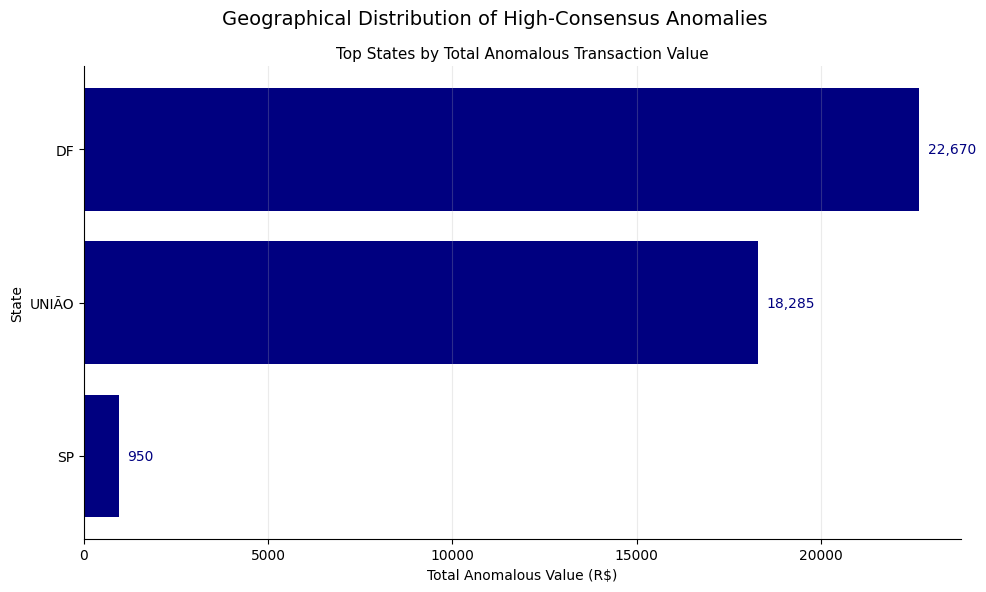

In [42]:
# Sort states by total anomalous value
df_plot_state = df_state_summary.sort_values(
    "Total_Anomalous_Value", ascending=True
)

plt.figure(figsize=(10, 6))

# Horizontal bar chart in navy blue
bars = plt.barh(
    df_plot_state["ESTADO_ESTIMADO"],
    df_plot_state["Total_Anomalous_Value"],
    color="navy"
)

# Title + subtitle
plt.suptitle(
    "Geographical Distribution of High-Consensus Anomalies",
    fontsize=14,
)
plt.title(
    "Top States by Total Anomalous Transaction Value",
    fontsize=11
)

# Axis labels
plt.xlabel("Total Anomalous Value (R$)")
plt.ylabel("State")

# Add numeric labels to each bar
max_value = df_plot_state["Total_Anomalous_Value"].max()
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + (0.01 * max_value),
        bar.get_y() + bar.get_height() / 2,
        f"{width:,.0f}",
        va='center',
        fontsize=10,
        color="navy"
    )

# Clean look
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid(axis="x", alpha=0.25)

plt.tight_layout()
plt.show()


### Government bodies (Nome dos Orgãos do Governo)

Next, we examine which government bodies (“Órgãos”) appear most frequently among the High Consensus transactions.

This step helps us understand whether suspicious patterns are concentrated in specific administrative units or spread across multiple institutions. If certain órgãos repeatedly appear in the top-risk group, this may indicate localized irregularities, operational bottlenecks, or structural vulnerabilities in those units.

To make this pattern easier to interpret, we visualize the frequency distribution using a bar chart. This reveals which órgãos are most represented among the highest-priority anomalies and supports targeted auditing by highlighting where unusual behaviors may be systematically occurring.

In [26]:
query_entity_risk = """
SELECT
    "NOME ÓRGÃO",
    COUNT(*) AS Anomaly_Count,
    SUM("VALOR TRANSAÇÃO") AS Total_Value_R,
    AVG("PRIORITY_SCORE") AS Avg_Priority
FROM
    df_high
GROUP BY
    "NOME ÓRGÃO"
ORDER BY
    Total_Value_R DESC
LIMIT
    10;
"""
df_org_summary = pysqldf(query_entity_risk)
print("Top 10 Agencies by Total Anomalous Value:")
display(df_org_summary)

Top 10 Agencies by Total Anomalous Value:


,NOME ÓRGÃO,Anomaly_Count,Total_Value_R,Avg_Priority
0,Fundação Instituto Brasileiro de Geografia e E...,12,11950.0,14992.403181
1,Instituto Chico Mendes de Conservação da Biodi...,17,10840.0,24412.529406
2,Instituto Nacional de Colonização e Reforma Ag...,9,8700.0,20699.522761
3,Polícia Federal,2,2014.6,10028.791152
4,"VALEC Engenharia, Construções e Ferrovias S.A.",3,2000.0,250151.079601
5,Comando da Aeronáutica,2,2000.0,13061.210686
6,Ministério do Meio Ambiente e Mudança do Clima...,2,1500.0,76568.565590
7,Presidência da República,1,1000.0,61557.428369
8,Fundação Escola Nacional de Administração Pública,1,970.0,10512.889897
9,Instituto de Pesquisa Econômica Aplicada,1,930.0,21386.336080


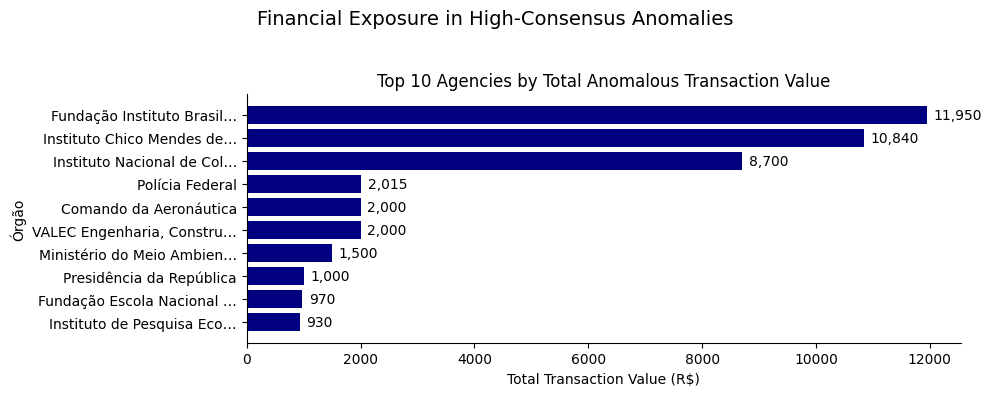

In [43]:
# Shorten long agency names
def shorten(name, max_len=25):
    return name if len(name) <= max_len else name[:max_len] + "…"

# Shortened labels to df_org_summary
df_org_summary["ORG_LABEL"] = df_org_summary["NOME ÓRGÃO"].apply(shorten)

# Sort for plotting
df_plot = df_org_summary.sort_values("Total_Value_R", ascending=True)

# Plot
plt.figure(figsize=(10, 4))

bars = plt.barh(df_plot["ORG_LABEL"], df_plot["Total_Value_R"], color='navy')

# Title + subtitle
plt.suptitle("Financial Exposure in High-Consensus Anomalies\n", fontsize=14)
plt.title("Top 10 Agencies by Total Anomalous Transaction Value", fontsize=12)

# Axis labels
plt.xlabel("Total Transaction Value (R$)")
plt.ylabel("Órgão")

# Numeric labels
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + (0.01 * df_plot["Total_Value_R"].max()),
        bar.get_y() + bar.get_height() / 2,
        f"{width:,.0f}",
        va="center",
        fontsize=10
    )
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.show()

### Who is spending the money?

This query examines which cardholders (ID_PORTADOR) appear most frequently within the High-Consensus anomaly subset, highlighting individuals whose spending patterns consistently triggered both anomaly-detection models. By grouping the results by holder ID and requiring at least two anomalous transactions, we focus on repeated behavior rather than isolated events.

The output ranks these holders by the total anomalous transaction value, allowing us to identify cases where recurring anomalies are also financially significant. This combination tends to reveal patterns that may merit deeper investigation—either due to repeated large-value withdrawals or because certain individuals exhibit unusual consistency in triggering high-priority risk scores.

Several cardholders show multiple high-consensus anomalies with totals between R$2,000 and R$4,000, while a few cases display comparatively lower transaction totals but extremely high maximum priority scores. These contrasting profiles suggest different risk dynamics: some individuals accumulate suspicious value over repeated transactions, while others may stand out due to particularly atypical behavior detected by the models.

In [28]:
query_portador_summary = """
SELECT
    "ID_PORTADOR",
    COUNT(*) AS Total_Anomalies,
    SUM("VALOR TRANSAÇÃO") AS Total_Anomaly_Value,
    MAX("PRIORITY_SCORE") AS Max_Priority
FROM
    df_high
GROUP BY
    "ID_PORTADOR"
HAVING
    Total_Anomalies > 1 -- Only look at Portadores who appear more than once
ORDER BY
    Total_Anomaly_Value DESC
LIMIT
    10;
"""
df_portador_volume = pysqldf(query_portador_summary)
print("Top 10 Portadores (Holders) by Anomaly Value:")
display(df_portador_volume)

Top 10 Portadores (Holders) by Anomaly Value:


,ID_PORTADOR,Total_Anomalies,Total_Anomaly_Value,Max_Priority
0,***.189.302-**MARIA DA GLORIA MONTEIRO DE SOUZA,4,4000.0,21315.208866
1,***.942.417-**MICHELLA PAULA CECHINEL REIS,3,3000.0,15727.222786
2,***.708.611-**DANILO BORGES NOGUEIRA,3,3000.0,15727.327797
3,***.524.761-**MAIARA SANTOS SANTANA,3,3000.0,15727.186912
4,***.901.820-**BRUNA BARROZO DALCIN,2,2000.0,13061.263058
5,***.604.191-**RAFAEL GOMES PEREIRA,2,2000.0,15727.083294
6,***.443.198-**IVALDO MARQUES DA SILVA,2,2000.0,65625.312647
7,***.264.331-**LEANDRO FRANCO PEDROZA,3,2000.0,653005.512950
8,***.484.016-**NILO ARAUJO DE FIGUEIREDO,2,1900.0,21315.321677
9,***.283.371-**ROBERT WILLIAM CARDOSO DE PAULA,2,1500.0,111462.768939


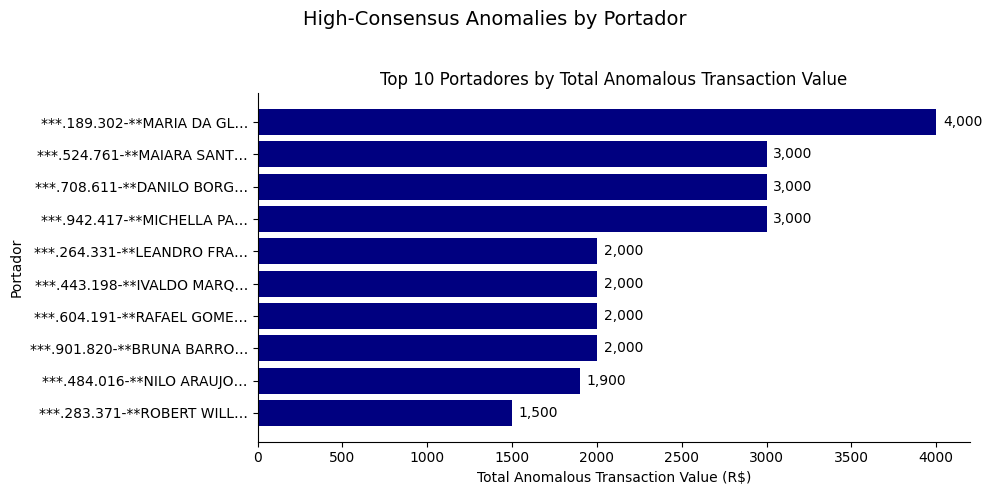

In [44]:
# --- Prepare plotting data ---
df_plot = df_portador_volume.copy()

def shorten_label(label, max_len=25):
    return label if len(label) <= max_len else label[:max_len] + "…"

df_plot["LABEL"] = df_plot["ID_PORTADOR"].apply(shorten_label)

# Sort for clearer plotting (ascending so the highest appears at the top)
df_plot = df_plot.sort_values("Total_Anomaly_Value", ascending=True)

# --- Plot ---
plt.figure(figsize=(10, 5))

bars = plt.barh(
    df_plot["LABEL"],
    df_plot["Total_Anomaly_Value"],
    color='navy'
)

# Titles
plt.suptitle("High-Consensus Anomalies by Portador\n", fontsize=14)
plt.title("Top 10 Portadores by Total Anomalous Transaction Value", fontsize=12)

# Axis labels
plt.xlabel("Total Anomalous Transaction Value (R$)")
plt.ylabel("Portador")

# Add value labels at the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + (0.01 * df_plot["Total_Anomaly_Value"].max()),
        bar.get_y() + bar.get_height() / 2,
        f"{width:,.0f}",
        va="center",
        fontsize=10
    )
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.show()

### "Sigiloso" or not?

To deepen our understanding of how classified info (sigiloso) relates to anomalous transactions, we analyze the variable SIGILOSO, which indicates whether each transaction is considered classified (1) or not classified (0).

Using a structured SQL query allows us to quantify not only how many transactions fall under each category, but also their financial impact and their average anomaly severity according to our priority score.

This breakdown helps answer two key questions:

- Are classified transactions disproportionately flagged as high-risk?
- Do classified transactions carry higher monetary values or priority scores?

This view is particularly useful because, if we observe that classified transactions consistently appear with higher anomaly counts or higher total financial exposure, it may indicate systematic issues in internal controls or data governance around restricted operations.

In [30]:
query_sigiloso_risk = """
SELECT
    SIGILOSO,
    COUNT(*) AS Transaction_Count,
    SUM("VALOR TRANSAÇÃO") AS Total_Value,
    AVG("PRIORITY_SCORE") AS Avg_Priority
FROM
    df_high
GROUP BY
    SIGILOSO
ORDER BY
    Transaction_Count DESC;
"""

df_sigiloso_summary = pysqldf(query_sigiloso_risk)
print("Classified (Sigiloso) vs Non-Classified Transactions:")
display(df_sigiloso_summary)

Classified (Sigiloso) vs Non-Classified Transactions:


,SIGILOSO,Transaction_Count,Total_Value,Avg_Priority
0,0,50,41904.6,36488.891419


All 47 transactions flagged as High Consensus anomalies were marked as SIGILOSO = 0, meaning none of them were classified or restricted transactions.

This is noteworthy because it suggests that the highest-risk patterns detected by the models occurred entirely in non-classified operations, which typically should be more transparent and easier to justify.

The complete absence of classified (SIGILOSO = 1) transactions in this high-risk subset may indicate:

- High-risk behavior is concentrated in regular, non-sensitive transactions
- Withdrawals (which dominate the high-risk cluster) are generally not executed under classified status
- The classification flag is not being consistently applied in risky contexts
- Maybe it was also more difficult for the models to analyse these types of transactions

This reinforces that the detected anomalies are emerging from ordinary operational activity, not from transactions intentionally marked as confidential.  

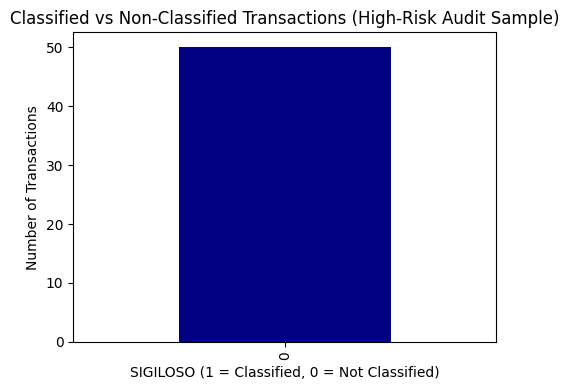

In [45]:
plt.figure(figsize=(5,4))

df_high['SIGILOSO'].value_counts().plot(kind='bar', color='navy')

plt.xlabel("SIGILOSO (1 = Classified, 0 = Not Classified)")
plt.ylabel("Number of Transactions")
plt.title("Classified vs Non-Classified Transactions (High-Risk Audit Sample)")

plt.tight_layout()
plt.show()

## Final Remarks — What the Manual Analysis Reveals

The manual review of the top-ranked cases provides a coherent picture of how the two anomaly-detection models behave in practice and how their signals translate into operational insights. Several consistent themes emerged across the SQL exploration, visual inspections, and cross-checks.

### The High Consensus group forms a small but very distinct subset. 
These cases tend to be homogeneous in structure: transactions are predominantly cash withdrawals (SAQUE/ATM), concentrated on specific individuals, and often repeated in a patterned manner. This is exactly the kind of convergence we hope to see when two different models flag the same behavior using unrelated mechanisms.

### Geographical concentration of anomalies. 
Many of the highest-risk transactions occur in states where, under normal circumstances, card-based payments would be entirely feasible and commonly used. The predominance of withdrawals in regions where electronic transactions are the standard option raises questions about the necessity—or intentions—behind these repeated cash operations.

### Temporal patterns reinforce the concern expressed above.
 It is particularly unusual that roughly one quarter of all flagged withdrawals occur on weekends, when administrative and operational activity is typically reduced. Such timing anomalies often signal intentional attempts to operate outside normal oversight windows.

### The financial side of the anomalies is remarkably regular. 
High-risk transactions cluster tightly around the same value ranges, often with fixed or near-fixed transaction amounts. This suggests behavior that is either rule-driven or intentionally structured, in contrast with the variability normally expected in legitimate administrative spending.

### Our temporal analysis indicates non-random timing. 
Certain month–weekday combinations recur across years, pointing to repeated operational routines rather than isolated events. This reinforces the idea that anomalies are not noise but part of stable behavior patterns. 

### Entities and beneficiaries shows that a small number of portadores and favorecidos account for a disproportionately large share of the total anomalous value. 
This concentration of risk is important: even without labels or ground-truth fraud indicators, the models succeed in isolating the individuals whose behavior systematically deviates from the broader population.

### None of the High Consensus transactions were marked as “sigiloso”. 
It means the highly anomalous activity tends to occur within the portion of the data that is not classified as sensitive. This helps eliminate one possible source of bias and increases confidence that the models are not just reacting to documentation status.

## Overall Interpretation

Taken together, these observations suggest that the models are capturing true structural irregularities, not artifacts of the dataset.
The convergence of LOF and IF on the same cases, the repeated transactional patterns, and the concentration of anomalous values in a small group all indicate that the prioritization strategy is behaving as intended: it surfaces cases that are both unusual and internally consistent enough to warrant further investigation.

In other words, the manual audit validates that the system is high-precision on the top end. The high consensus cases flagged for review appear highly coherent and operationally interpretable. The next step would be to connect these findings with domain-level knowledge or investigative feedback to refine thresholds and improve the scoring pipeline over time.